# This is the classifier for the butterfly dataset

Below there is the machine learning workflow pipeline

Import packages and device selection

In [1]:
import os
import cv2
from PIL import Image
import atom
import atom.data_cleaning as dc
import atom.feature_engineering as fe
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchinfo import summary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = '../data/images'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device: ", device)

Using device:  cuda


## Dataset building and preprocessing

In [17]:
data = []
labels = []
path = '../data/images'
folder = os.listdir(path)
for file in folder:
    img = cv2.imread(str(os.path.join(path, file)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    data.append(img)
    labels.append(int(file[:3]) - 1)
labels = np.array(labels)
labels = labels.reshape(-1, 1)
label_dict = {0: 'Danaus plexippus',
              1: 'Heliconius charitonius',
              2: 'Heliconius erato',
              3: 'Junonia coenia',
              4: 'Lycaena phlaeas',
              5: 'Nymphalis antiopa',
              6: 'Papilio cresphontes',
              7: 'Pieris rapae',
              8: 'Vanessa atalanta',
              9: 'Vanessa cardui'}

In [3]:
print([label_dict[labels[i, 0]] for i in range(10)]) 

['Lycaena phlaeas', 'Vanessa cardui', 'Vanessa cardui', 'Junonia coenia', 'Lycaena phlaeas', 'Nymphalis antiopa', 'Papilio cresphontes', 'Danaus plexippus', 'Pieris rapae', 'Nymphalis antiopa']


In [19]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        data = Image.fromarray(data.astype('uint8'), 'RGB')
        if self.transform:
            data = self.transform(data)
        labels = torch.tensor(self.labels[idx], dtype=torch.long)
        return data, labels

In [18]:
trans = transforms.Compose([
    transforms.ToTensor()
])
dataset = MyDataset(data, labels, transform=trans)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)
total_sum = torch.zeros(3)
total_count = 0
for images, _ in dataloader:
    total_sum += images.sum(dim=[0, 2, 3])
    total_count += images.numel() / images.shape[1]
mean = total_sum / total_count
sum_of_squared_diff = torch.zeros(3)
for images, _ in dataloader:
    sum_of_squared_diff += ((images - mean.unsqueeze(1).unsqueeze(2))**2).sum(dim=[0, 2, 3])
std = torch.sqrt(sum_of_squared_diff / total_count)
mean = [mean[0].item(), mean[1].item(), mean[2].item()]
std = [std[0].item(), std[1].item(), std[2].item()]

ValueError: unrecognized image mode

In [6]:
print(mean, std)

[0.4616279900074005, 0.4468429684638977, 0.3207762539386749] [0.2861473262310028, 0.2681962549686432, 0.27681371569633484]


In [ ]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dataset = MyDataset(data, labels, transform=trans)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
data = []
for img, _ in dataloader:
    data.append(img.numpy())
data = np.concatenate(data, axis=0)

#### Display some samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

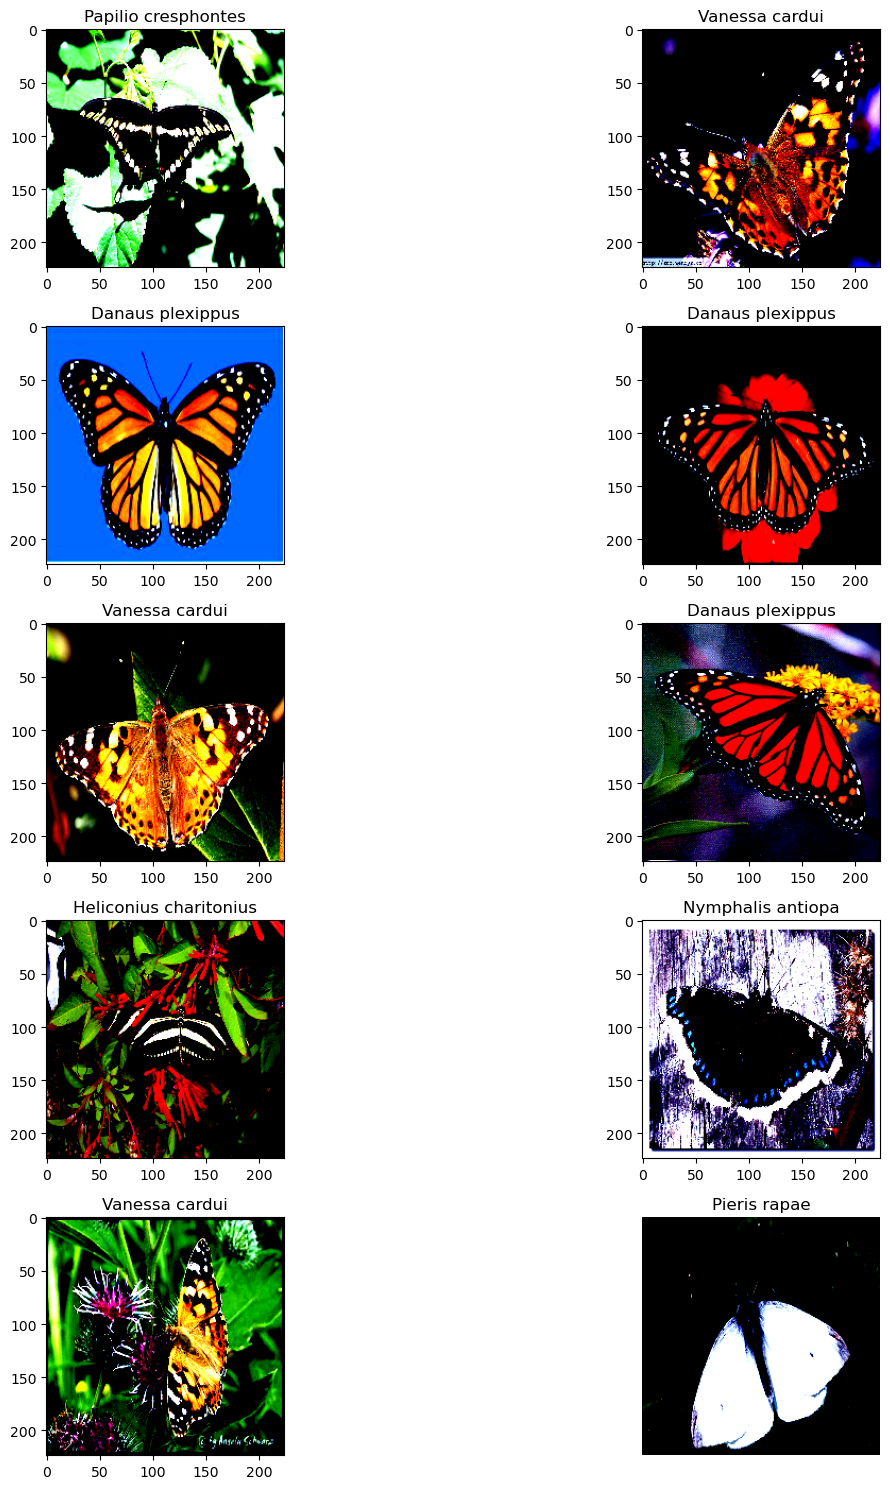

In [15]:
images = data.transpose((0, 2, 3, 1))
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=np.random.randint(0,len(labels))
        ax[i,j].imshow(images[l])
        ax[i,j].set_title(str(label_dict[labels[l, 0]]))
plt.axis('off')        
plt.tight_layout()

#### Display dataset distribution

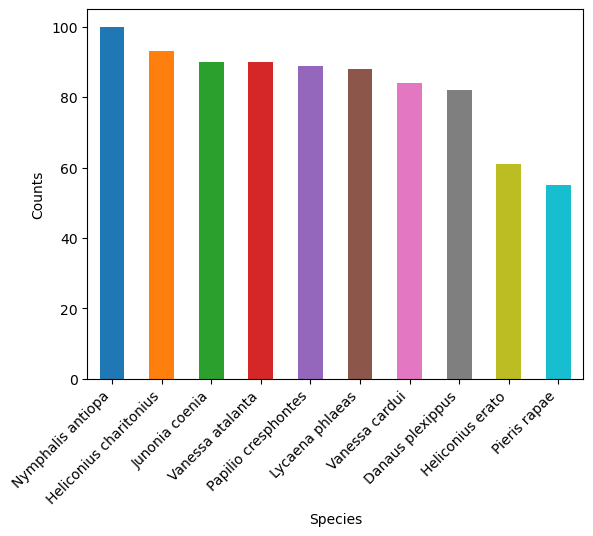

In [35]:
df = pd.DataFrame(labels, columns=['labels'])
df['labels'] = df['labels'].map(label_dict)
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = [cycle[i % len(cycle)] for i in range(len(df['labels'].unique()))]
df['labels'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Species')
plt.ylabel('Counts')
plt.xticks(rotation=45, ha='right')
plt.show()

Flatten data for ingestion to Atom objects

In [36]:
data = data.reshape(len(data), -1)

Use this to revert flatten data to rgb pixels 224x224

## Data cleaning

Use this to check dataset

In [47]:
print(data.shape, labels.shape)
print(data)
print(labels)

(832, 3, 224, 224) (832, 1)
[[[[-0.55409735 -0.5261427  -0.51216537 ... -0.13477714 -0.0509131
     0.03295095]
   [-0.49818802 -0.55409735 -0.54012    ... -0.16273183 -0.10682247
    -0.02295842]
   [-0.40034664 -0.47023332 -0.51216537 ... -0.17670918 -0.13477714
    -0.0509131 ]
   ...
   [-0.10682247 -0.37239194 -0.48421067 ... -0.65193874 -0.67989343
    -0.7358028 ]
   [-0.2605732  -0.47023332 -0.48421067 ... -0.7218255  -0.7358028
    -0.7917122 ]
   [-0.3584146  -0.33045992 -0.00898108 ... -0.7777349  -0.7637575
    -0.7917122 ]]

  [[ 0.48927915  0.45936674  0.48927915 ...  0.8183157   0.92300916
     1.0127465 ]
   [ 0.48927915  0.48927915  0.48927915 ...  0.8183157   0.92300916
     1.0127465 ]
   [ 0.549104    0.51919156  0.51919156 ...  0.8033595   0.87814057
     0.9678778 ]
   ...
   [-0.00427582 -0.15383789 -0.22861893 ...  0.44441053  0.45936674
     0.44441053]
   [-0.04914444 -0.19870651 -0.13888168 ...  0.42945433  0.44441053
     0.42945433]
   [-0.03418823 -0.00427

For a classification task, you can follow these steps in the given order to ensure your data is clean and ready for modeling:

* **Handling Outliers**: Detect and manage outliers in your dataset.
* **Balancing the Data**: Use the Balancer class to address any class imbalance during cross validation.
* **Scaling the Feature Set**: Standardize your dataset to ensure all features are on a similar scale.

This sequence helps in systematically preparing your data for a classification model.

In [12]:
data, labels = (dc.Pruner(strategy=['lof', 'iforest'],
                   device='cpu',
                   engine='sklearn',
                   verbose=2,
                   iforest={'contamination': 'auto', 'bootstrap': True, 'n_jobs': -1, 'random_state': 1},
                   lof={'n_neighbors': 20, 'contamination': 'auto', 'n_jobs': -1}
                   )
          .fit_transform(data, labels))

Fitting Pruner...
Pruning outliers...
 --> The LocalOutlierFactor detected 13 outliers.
 --> The IsolationForest detected 277 outliers.
 --> Dropping 13 outliers.


In [38]:
data = data.reshape(len(data), 224, 224, 3)
cat_labels = F.one_hot(torch.tensor(labels, requires_grad=False), num_classes=10).numpy()

## Trainset preparation